In [1]:
%matplotlib inline

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
# %qtconsole

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr

import logging

logging.basicConfig(level=logging.INFO)

In [3]:
from src.load_data import load_data

epoch_key = ('bon', 3, 2)

data = load_data(epoch_key)

INFO:src.load_data:Loading data...
INFO:src.load_data:Finding multiunit high synchrony events...
INFO:src.load_data:Finding ripple times...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.02,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)
INFO:src.load_data:Estimating gamma power...
INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1000, time_halfbandwidth_product=1,
           time_window_duration=0.1, time_window_step=0.1,
           detrend_type='constant', start_time=3729.0257, n_tapers=1)


In [4]:
from replay_identification import ReplayDetector
from src.parameters import detector_parameters

replay_detector = ReplayDetector(**detector_parameters)
replay_detector

ReplayDetector(infer_track_interior=True,
        lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
        lfp_model_kwargs={'n_components': 1, 'max_iter': 200, 'tol': 1e-06},
        movement_state_transition_type='w_track_1D_random_walk',
        movement_var=4.0,
        multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
        multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
        multiunit_occupancy_kwargs={'bandwidth': array([6.])},
        multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
        place_bin_size=1.0, position_range=None, replay_speed=1,
        replay_state_transition_penalty=1e-05, speed_knots=None,
        speed_threshold=4.0, spike_model_knot_spacing=10,
        spike_model_penalty=0.5)

In [5]:
track_labels = data['position_info'].arm_name

replay_detector.fit(
    is_ripple=data['is_ripple'], speed=data['position_info'].speed,
    position=data['position_info'].linear_position2,
    lfp_power=data['ripple_power'], spikes=data['spikes'],
    multiunit=data['multiunit'], track_labels=track_labels)

INFO:replay_identification.decoders:Fitting speed model...
INFO:replay_identification.decoders:Fitting LFP power model...
INFO:replay_identification.decoders:Fitting spiking model...


INFO:replay_identification.decoders:Fitting multiunit model...


INFO:replay_identification.decoders:Fitting replay movement state transition...


INFO:replay_identification.decoders:Fitting replay state transition...


ReplayDetector(infer_track_interior=True,
        lfp_model=<class 'sklearn.mixture.bayesian_mixture.BayesianGaussianMixture'>,
        lfp_model_kwargs={'n_components': 1, 'max_iter': 200, 'tol': 1e-06},
        movement_state_transition_type='w_track_1D_random_walk',
        movement_var=4.0,
        multiunit_density_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
        multiunit_model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.])},
        multiunit_occupancy_kwargs={'bandwidth': array([6.])},
        multiunit_occupancy_model=<class 'replay_identification.multiunit_likelihood.NumbaKDE'>,
        place_bin_size=1.0, position_range=None, replay_speed=1,
        replay_state_transition_penalty=1e-05, speed_knots=None,
        speed_threshold=4.0, spike_model_knot_spacing=10,
        spike_model_penalty=0.5)

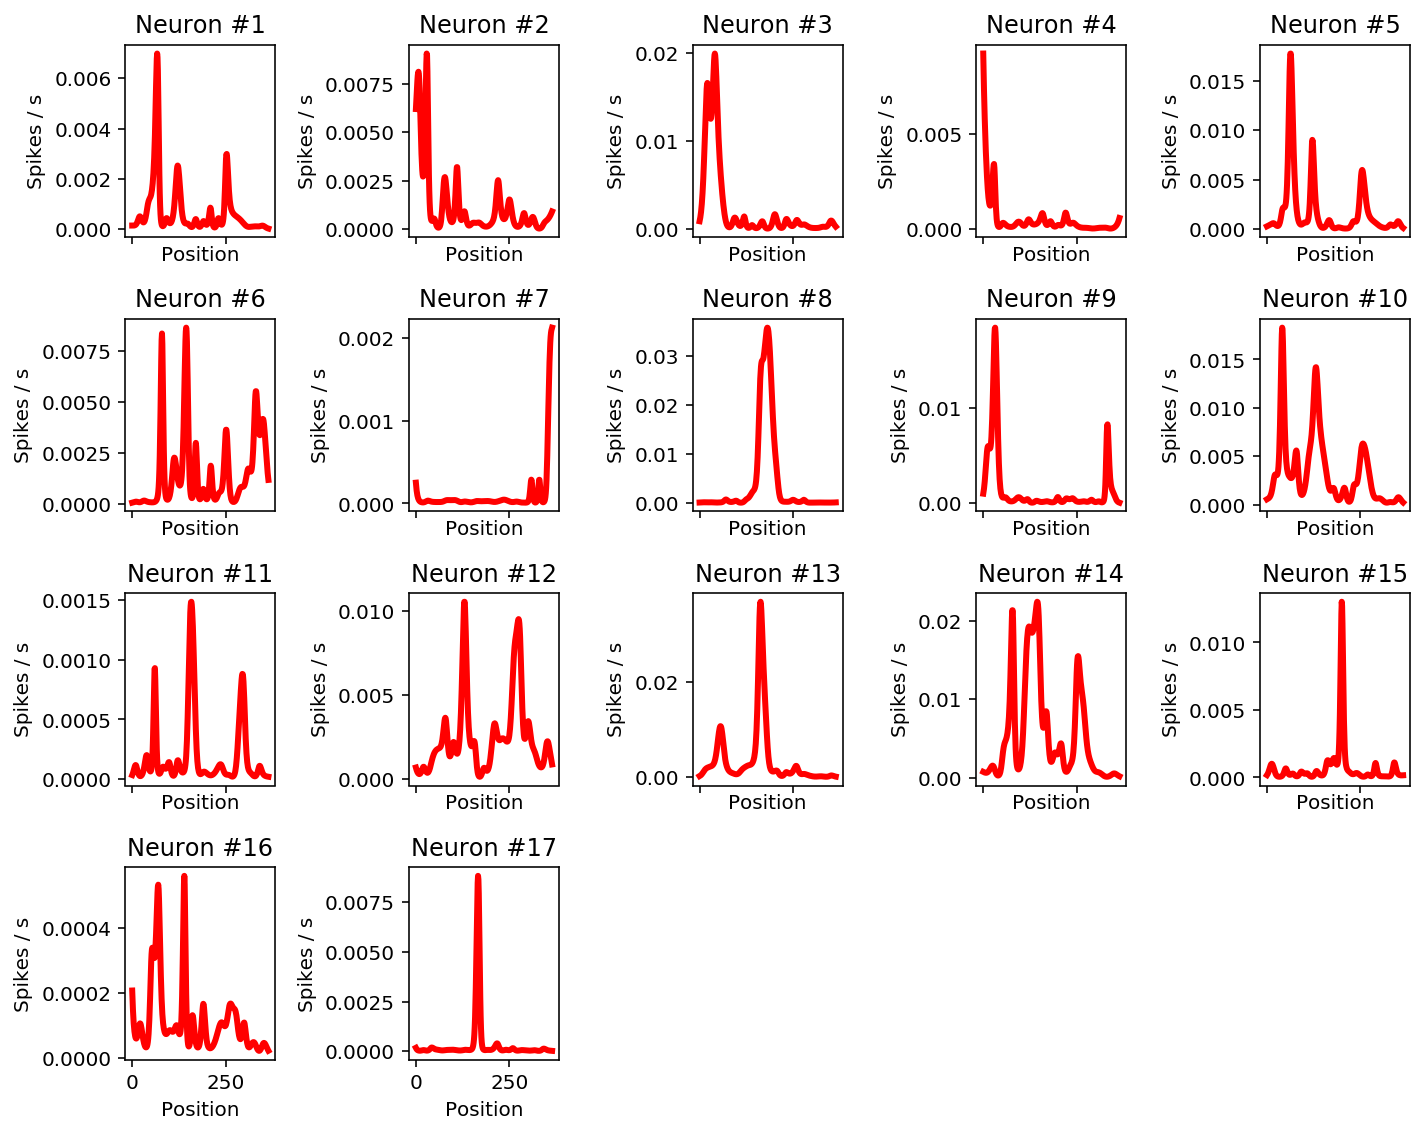

In [6]:
replay_detector.plot_fitted_place_fields()

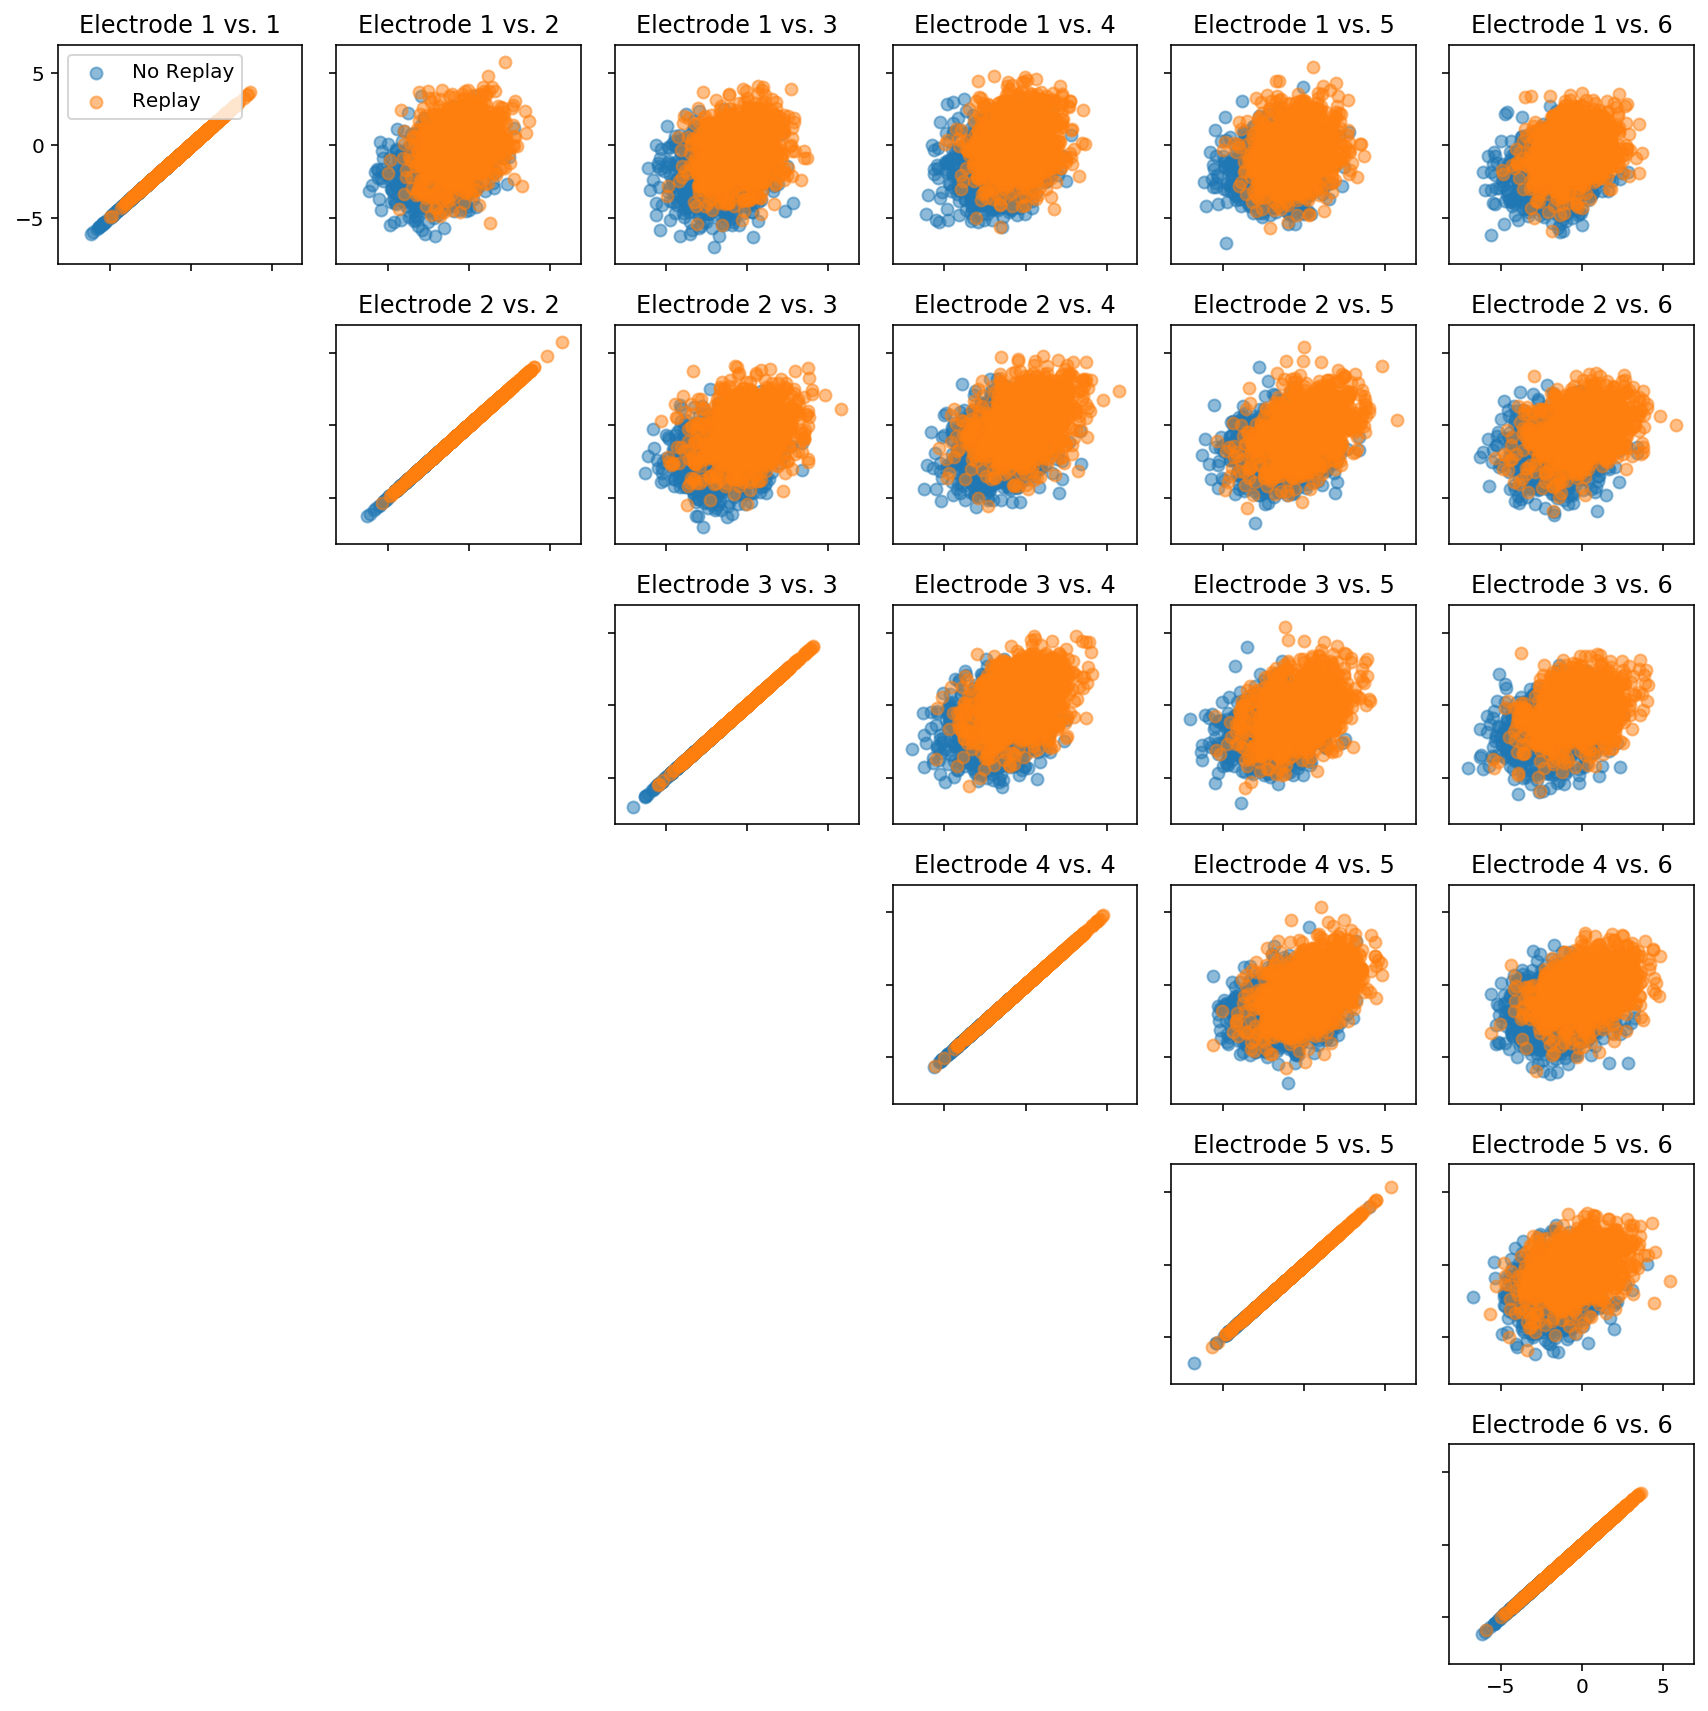

In [7]:
replay_detector.plot_fitted_lfp_power_model()

In [8]:
likelihoods = ['spikes']
use_smoother = True

detector_results = replay_detector.predict(
    speed=data['position_info'].speed,
    position=data['position_info'].linear_position2,
    spikes=data['spikes'], multiunit=data['multiunit'],
    lfp_power=data['ripple_power'],
    time=data['position_info'].index,
    use_likelihoods=likelihoods,
    use_smoother=use_smoother)


INFO:replay_identification.decoders:Predicting spikes likelihood...


INFO:replay_identification.decoders:Predicting replay probability and density...
INFO:replay_identification.decoders:Smoothing...


In [9]:
detector_results = detector_results.drop(['likelihood', 'causal_posterior']).sel(state='Replay')
detector_results

<xarray.Dataset>
Dimensions:             (position: 367, time: 930994)
Coordinates:
  * time                (time) timedelta64[ns] 01:02:09.025700 ... 01:17:40.018700
  * position            (position) float64 -0.4988 0.4988 1.496 ... 363.6 364.6
    state               <U9 'Replay'
Data variables:
    acausal_posterior   (time, position) float64 0.0 0.0 ... 5.545e-52 5.547e-52
    replay_probability  (time) float64 0.0 2.372e-12 ... 1.666e-49 1.666e-49

In [10]:
from src.summarize_replay import (add_epoch_info_to_dataframe, compare_overlap,
                                  decode_replays, get_replay_times,
                                  get_replay_triggered_power,
                                  summarize_replays)

data_source='sorted_spikes'
replay_info, is_replay = get_replay_times(detector_results)
replay_info = add_epoch_info_to_dataframe(replay_info, epoch_key,
                                          data_source)
replay_info.head()

,replay_number,start_time,end_time,duration,max_probability,animal,day,epoch,data_source
replay_id,,,,,,,,,
bon_03_02_001_sorted_spikes,1,01:02:09.502700,01:02:10.761700,1.259,0.998786,bon,3,2,sorted_spikes
bon_03_02_002_sorted_spikes,2,01:02:10.800700,01:02:11.486700,0.686,0.999994,bon,3,2,sorted_spikes
bon_03_02_003_sorted_spikes,3,01:02:21.833700,01:02:21.893700,0.060,0.980504,bon,3,2,sorted_spikes
bon_03_02_004_sorted_spikes,4,01:02:30.387700,01:02:30.468700,0.081,0.851771,bon,3,2,sorted_spikes
bon_03_02_005_sorted_spikes,5,01:02:47.472700,01:02:47.521700,0.049,0.920325,bon,3,2,sorted_spikes


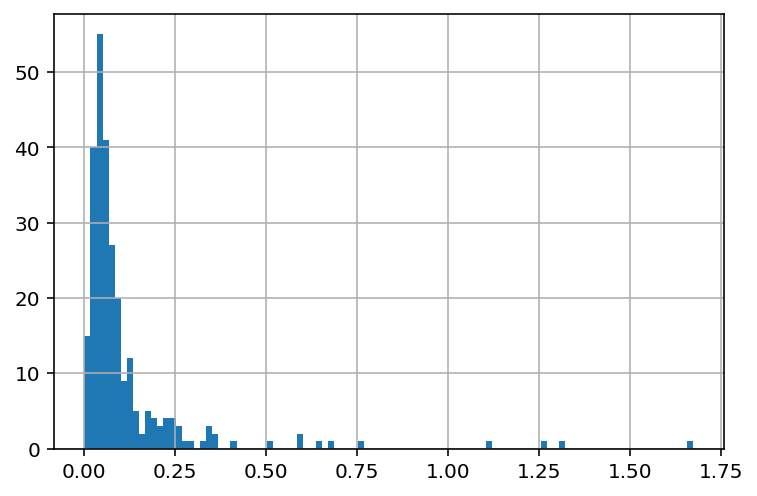

In [11]:
replay_info.duration.hist(bins=100)

In [12]:

# decoder_results = xr.concat(
#     [detector_results.sel(time=slice(row.start_time, row.end_time), state='Replay').posterior
#      for row in replay_info.itertuples()], dim=replay_info.index)
# decoder_results

In [ ]:
from src.summarize_replay import get_replay_metrics
replay_metrics = []

for row in replay_info.itertuples():
    posterior = detector_results.acausal_posterior.sel(time=slice(row.start_time, row.end_time))
    replay_metrics.append(get_replay_metrics(row.start_time, row.end_time, posterior, **data))